In [2]:
%load_ext autoreload
%autoreload 2

In [43]:
from utils import imageUtils

In [3]:
import numpy as np
import os

import chainer
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

root = '/home/wei/Data/Loop_detection'

In [56]:
from chainercv.visualizations import vis_bbox

In [5]:
from utils import DefectDetectionDataset

In [6]:
dataset = DefectDetectionDataset.DefectDetectionDataset(split='train')

In [7]:
dataset_test = DefectDetectionDataset.DefectDetectionDataset(split='test')

(28, 4)
(28,)


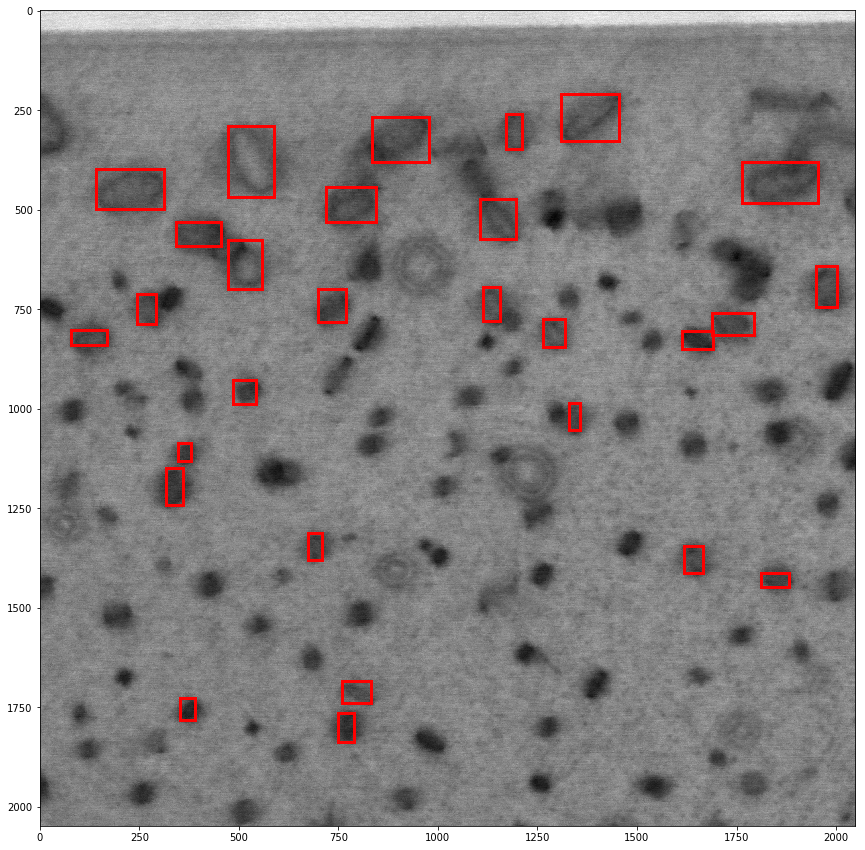

In [8]:

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[200]
print(bbox.shape)  # (2, 4)
print(label.shape)  # (2,)
vis_bbox(img, bbox, label, ax=ax1)
plt.show()

# Training RCNN

In [96]:
import numpy as np

import chainer
from chainer.datasets import ConcatenatedDataset
from chainer.datasets import TransformDataset
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger

from chainercv.datasets import voc_bbox_label_names
from chainercv.datasets import VOCBboxDataset
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms


class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = transforms.resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale

In [109]:
bbox_label_names = ('loop')

In [ ]:
np.random.seed(0)
train_data = DefectDetectionDataset.DefectDetectionDataset()
test_data = DefectDetectionDataset.DefectDetectionDataset()
faster_rcnn = FasterRCNNVGG16(n_fg_class=1,pretrained_model='imagenet')
faster_rcnn.use_preset('evaluate')
model = FasterRCNNTrainChain(faster_rcnn)
chainer.cuda.get_device_from_id(0).use()
model.to_gpu()
optimizer = chainer.optimizers.MomentumSGD(lr=1e-3, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
train_data = TransformDataset(train_data, Transform(faster_rcnn))
train_iter = chainer.iterators.SerialIterator(
    train_data, batch_size=1)
test_iter = chainer.iterators.SerialIterator(
    test_data, batch_size=1, repeat=False, shuffle=False)
updater = chainer.training.updater.StandardUpdater(
    train_iter, optimizer, device=0)
trainer = training.Trainer(
    updater, (700, 'iteration'), out='result')
trainer.extend(
    extensions.snapshot_object(model.faster_rcnn, 'snapshot_model.npz'),
    trigger=(700, 'iteration'))
trainer.extend(extensions.ExponentialShift('lr', 0.1),
               trigger=(500, 'iteration'))
log_interval = 3, 'iteration'
plot_interval = 100, 'iteration'
print_interval = 3, 'iteration'
trainer.extend(chainer.training.extensions.observe_lr(),
               trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(
    ['iteration', 'epoch', 'elapsed_time', 'lr',
     'main/loss',
     'main/roi_loc_loss',
     'main/roi_cls_loss',
     'main/rpn_loc_loss',
     'main/rpn_cls_loss',
     'validation/main/map',
     ]), trigger=print_interval)
trainer.extend(extensions.ProgressBar(update_interval=2))
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss'],
            file_name='loss.png', trigger=plot_interval
        ),
        trigger=plot_interval
    )
  
trainer.extend(
    DetectionVOCEvaluator(
        test_iter, model.faster_rcnn, use_07_metric=True,
        label_names=voc_bbox_label_names),
    trigger=ManualScheduleTrigger(
        [500, 700], 'iteration'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.run()

# Testing

In [8]:
from chainercv.links import FasterRCNNVGG16
bbox_label_names = ('loop')

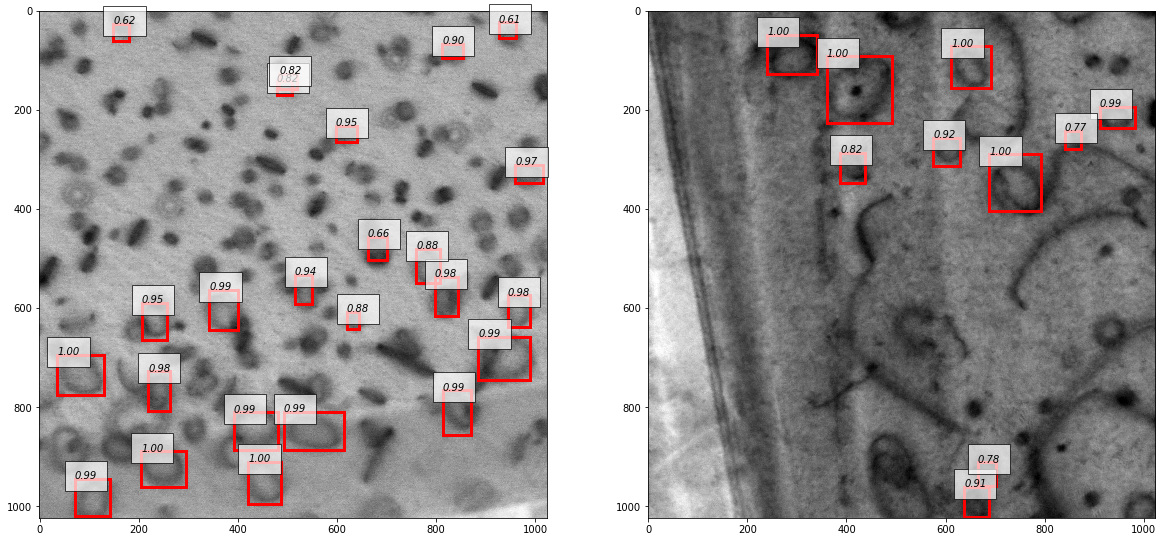

In [9]:
img_0, bbs_1, _ = dataset_test[3]
img_1, bbs_2, _ = dataset_test[14]
model = FasterRCNNVGG16(n_fg_class=1, pretrained_model='result/snapshot_model_70000.npz')
chainer.cuda.get_device_from_id(0).use()
model.to_gpu()
model.score_thresh = 0.6
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict([img_0, img_1])

# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bboxes[0], labels[0], scores[0], ax=ax1)
vis_bbox(img_1, bboxes[1], labels[1], scores[1], ax=ax2)
plt.show()

In [144]:
img_0, bbs_1, _ = dataset_test[3]

In [146]:
subimages = imageUtils.cropImage(img_0,bbs_1)

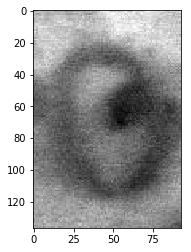

In [158]:
imageUtils.showImage(subimages[10])

In [83]:
width[width>70] = 0

In [84]:
width

array([ 0.,  0., 38., 69.,  0., 57., 60., 44.,  0.,  0.,  0., 34., 33.,
        0.,  0., 40., 51., 60., 42., 51., 27., 59., 38., 43., 43., 57.,
       19., 18., 48., 39., 51., 49.], dtype=float32)

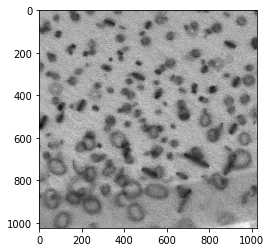

In [22]:
plt.imshow(img_0.transpose((1,2,0))[:,:,2], cmap='gray')

In [47]:
bbox = bbs_1[2,:]
bbox = bbox.astype(int)

In [48]:
image = img_0[:,bbox[0]:bbox[2], bbox[1]:bbox[3]]

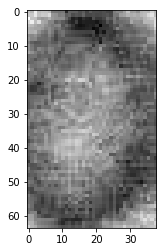

In [49]:
imageUtils.showImage(image)

In [12]:
bboxes[0]

array([[ 888.8418  ,  204.89041 ,  960.359   ,  295.15958 ],
       [ 910.5011  ,  421.25943 ,  995.01794 ,  487.12576 ],
       [ 694.39374 ,   35.839554,  775.45465 ,  130.0773  ],
       [ 810.62006 ,  392.32684 ,  887.2164  ,  481.68164 ],
       [ 766.0133  ,  814.125   ,  856.3307  ,  870.08655 ],
       [ 563.5879  ,  342.5347  ,  643.8408  ,  401.26785 ],
       [ 657.8813  ,  885.89746 ,  746.1867  ,  990.0481  ],
       [ 809.59314 ,  492.75342 ,  887.10144 ,  613.9418  ],
       [ 944.2717  ,   70.657005, 1020.0995  ,  142.66608 ],
       [ 536.82263 ,  797.39    ,  615.23047 ,  843.6626  ],
       [ 727.6594  ,  219.0235  ,  807.29346 ,  263.32303 ],
       [ 574.68066 ,  944.6372  ,  638.2722  ,  990.82544 ],
       [ 311.28778 ,  960.38513 ,  347.73553 , 1016.5028  ],
       [ 231.7215  ,  598.2912  ,  263.8913  ,  640.6928  ],
       [ 589.04083 ,  205.76518 ,  664.7939  ,  257.28217 ],
       [ 533.1053  ,  515.5018  ,  592.06915 ,  549.98627 ],
       [  66.590416,  81

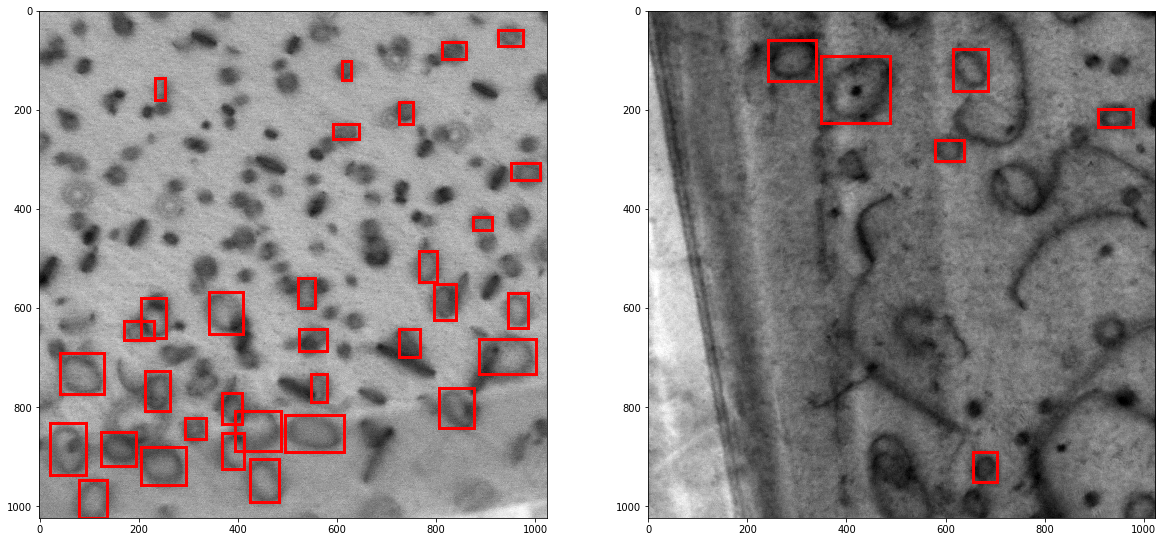

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bbs_1, ax=ax1)
vis_bbox(img_1, bbs_2, ax=ax2)
plt.show()

In [19]:
data_dir = root
images_file = os.path.join(data_dir, 'images.txt')
f = open(images_file)

In [20]:
images = [line.strip() for line in f]

In [38]:
bbs_file = os.path.join(root, "bounding_boxes", str('0501_300kx_1nm_clhaadf3_0031.jpg'[0:-4] +'.txt'))

In [47]:
bbs = np.stack([line.strip().split() for line in open(bbs_file)]).astype(np.float32)

In [48]:
bbs.shape

(7, 4)

In [52]:
np.stack([1]*bbs.shape[0]).astype(np.int32)

array([1, 1, 1, 1, 1, 1, 1], dtype=int32)